In [2]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.stats import norm
from typing import Dict, Optional, Tuple, Union

import torch
import gpytorch
from torch import Tensor
from torch.autograd import Function
from botorch.fit import fit_gpytorch_model
from botorch.models.model import Model
from botorch.models import SingleTaskGP
from botorch.models import FixedNoiseGP
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.kernels import MaternKernel
from gpytorch.distributions import MultivariateNormal
from torch import optim
from torch.autograd import grad
from botorch.optim import optimize_acqf
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.acquisition import ExpectedImprovement
from botorch.utils.probability.utils import (
    ndtr as Phi,
    phi,
)
from botorch.acquisition.analytic import _scaled_improvement
from botorch.acquisition.analytic import _ei_helper
from botorch.acquisition.objective import PosteriorTransform
from botorch.utils.transforms import convert_to_target_pre_hook, t_batch_mode_transform

In [4]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [5]:
def fit_gp_model(X, Y, Yvar=None):
    if X.ndim == 1:
        X = X.unsqueeze(dim=-1)
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim=-1)
    model = FixedNoiseGP(X, Y, torch.ones(Y.shape) * 1e-4, outcome_transform=Standardize(m=Y.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [140]:
from botorch.test_functions import Hartmann

# from botorch.acquisition import ExpectedImprovement
maximize = True

torch.manual_seed(42)

objective = Hartmann(negate=maximize)

x = torch.zeros(20, 6, device=device, dtype=torch.float64, requires_grad=True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
EI_best = [best_f] # This will store the best value

for i in range(24):
    
    # Fit the model
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    print()

/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized (mean = tensor([0.], dtype=torch.float64), std = tensor([0.], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Iteration: 0
new point: [[0.54205287 0.9037734  0.955588   0.87108034 0.90913326 0.93453425]]
new value: 0.0004955089534632862
best oberved value: 0.005089112851766937

Iteration: 1
new point: [[0.4637691  0.3236229  0.         0.09716811 0.07797979 0.07639764]]
new value: 0.057641953229904175
best oberved value: 0.057641953229904175

Iteration: 2
new point: [[0.6031983  0.42031324 0.         0.12553987 0.10050024 0.09839515]]
new value: 0.07206776738166809
best oberved value: 0.07206776738166809

Iteration: 3
new point: [[0.6302095  0.6106814  0.         0.08343226 0.07109974 0.07518536]]
new value: 0.07469437271356583
best oberved value: 0.07469437271356583

Iteration: 4
new point: [[0.7669152  0.5063816  0.         0.05903016 0.00891681 0.18636972]]
new value: 0.019570741802453995
best oberved value: 0.07469437271356583

Iteration: 5
new point: [[0.5572271  0.60765094 0.         0.145615   0.15361169 0.00750974]]
new value: 0.19246189296245575
best oberved value: 0.19246189296245575

In [139]:
objective(torch.tensor([[0.20169,0.150011,0.476874,0.275332,0.311652,0.6573]]))

tensor([3.3224])

Text(0.5, 1.0, 'Performance of EI policy')

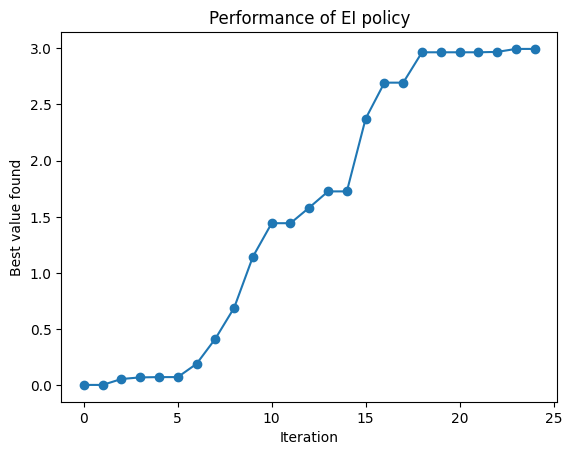

In [142]:
plt.plot(EI_best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy")

In [145]:
class GittinsIndexFunction(Function):
    @staticmethod
    def forward(X: torch.Tensor, mean: torch.Tensor, sigma: torch.Tensor, cost: float, maximize: bool, bounds: torch.Tensor, eps: float):
        
        def cost_adjusted_expected_improvement(best_f):
            u = _scaled_improvement(mean, sigma, best_f, maximize)
            return sigma * _ei_helper(u) - cost

        size = X.size()[0]
        l = bounds[0]*torch.ones(size)
        h = bounds[1]*torch.ones(size)
        m = (h + l) / 2

        if maximize:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) < 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) > 0):
                h = 2 * h
        else:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) > 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) < 0):
                h = 2 * h

        # Bisection method
#         while torch.max(torch.abs(cost_adjusted_expected_improvement(best_f=m))) >= eps:
        for _ in range(100):
            sgn_m = torch.sign(cost_adjusted_expected_improvement(best_f=m))
            if maximize:
                l = torch.where(sgn_m >= 0, m, l)
                h = torch.where(sgn_m <= 0, m, h)
            else:
                l = torch.where(sgn_m <= 0, m, l)
                h = torch.where(sgn_m >= 0, m, h)
            m = (h + l) / 2
            
        return m
    
    @staticmethod
    def setup_context(ctx, inputs, output):
        X, mean, sigma, cost, maximize, bounds, eps = inputs
        
        # Save u for backward computation
        u = _scaled_improvement(mean, sigma, output, maximize)
        
        # Save values needed in the backward pass
        ctx.save_for_backward(X, mean, sigma, u)
        
        # Save boolean flag directly in ctx
        ctx.maximize = maximize  

    @staticmethod
    def backward(ctx, grad_output):
                
        # Retrieve saved tensors
        X, mean, sigma, u = ctx.saved_tensors
        maximize = ctx.maximize  # Retrieve the boolean flag directly from ctx
                
        # Gradient of mean function with respect to x
        dmean_dX = grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), retain_graph=True, allow_unused=True)[0].clone()

        # Gradient of the std function with respect to x
        dsigma_dX = grad(outputs=sigma, inputs=X, grad_outputs=torch.ones_like(sigma), retain_graph=True, allow_unused=True)[0].clone()
        
        # Check if gradients are None and handle accordingly
        if dmean_dX is None or dsigma_dX is None:
            raise RuntimeError("Gradients could not be computed for one or more components.")
        
        # Compute the gradient of the Gittins acquisition function
        if maximize:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX + phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))
        else:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX - phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))

        return grad_X, None, None, None, None, None, None

In [146]:
class GittinsIndex(AnalyticAcquisitionFunction):
    r"""Single-outcome Gittins Index (analytic).

    Computes Gittins index using the analytic formula for a Normal posterior distribution. Unlike the
    MC-based acquisition functions, this relies on the posterior at single test
    point being Gaussian (and require the posterior to implement `mean` and
    `variance` properties). Only supports the case of `q=1`. The model must be
    single-outcome.

    `GI(x) = argmin_g |E(max(f(x) - g, 0))-cost|,`

    where the expectation is taken over the value of stochastic function `f` at `x`.

    Example:
        >>> model = SingleTaskGP(train_X, train_Y)
        >>> GI = GittinsIndex(model, cost=0.05)
        >>> gi = GI(test_X)
        
    """

    def __init__(
        self,
        model: Model,
        cost: float,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        bounds: torch.Tensor = torch.tensor([[-1.0], [1.0]], dtype=torch.float64),
        eps: float = 1e-6
    ):
        r"""Single-outcome Gittins Index (analytic).
        
        Args:
            model: A fitted single-outcome model.
            cost: Either a scalar or a `b`-dim Tensor (batch mode) representing
                the cost function.
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem.
            bounds: A `2 x d` tensor of lower and upper bounds for each column of `X`.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.cost = cost
        self.maximize = maximize
        self.bounds = bounds
        self.eps = eps
      
        
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate Gittins Index on the candidate set X using bisection method.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.
                Gittins Index is computed for each point individually,
                i.e., what is considered are the marginal posteriors, not the joint.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Gittins Index values at the
            given design points `X`.
        """
        
        mean, sigma = self._mean_and_sigma(X)
#         mean = self.model.posterior(X).mean.squeeze(-2).squeeze(-1)
#         sigma = self.model.posterior(X).variance.sqrt().squeeze(-2).squeeze(-1)
            
        return GittinsIndexFunction.apply(X, mean, sigma, self.cost, self.maximize, self.bounds, self.eps)

In [ ]:
from botorch.test_functions import Hartmann

In [147]:
maximize = False

torch.manual_seed(42)

objective = Hartmann(negate=maximize)

x = torch.rand(20, 6, device=device, dtype=torch.float64, requires_grad=True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
best = [best_f] # This will store the best value

for i in range(3):
    
    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize GI
    custom_GI = GittinsIndex(model=model, cost=cost, maximize=maximize)
    new_point, new_point_GI = optimize_acqf(
        acq_function=custom_GI,
        bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.86801106 0.06894385 0.30462477 0.452088   0.93624145 0.12362098]]
new value: -0.0004979089135304093
best oberved value: -0.9083012186312333

Iteration: 1
new point: [[0.9630471  0.6662515  0.10270409 0.5119464  0.94016486 0.29126427]]
new value: -0.00394719373434782
best oberved value: -0.9083012186312333

Iteration: 2
new point: [[0.8677242  0.0619388  0.2928276  0.44136688 0.95339125 0.12808575]]
new value: -0.00043707049917429686
best oberved value: -0.9083012186312333



In [173]:
# from torch.autograd import gradcheck

# Prepare the inputs for gradcheck
input_x = torch.rand(5,1,6, dtype=torch.float64, requires_grad=True)

# Run gradcheck
test = gradcheck(custom_GI, (input_x,), eps=1e-6, atol=1e-6)
print(test)

True


In [176]:
input_x

tensor([[[0.0434, 0.9703, 0.4873, 0.6383, 0.4596, 0.6911]],

        [[0.6702, 0.5696, 0.1993, 0.1924, 0.7441, 0.8223]],

        [[0.8466, 0.5131, 0.7983, 0.8283, 0.3044, 0.7010]],

        [[0.7686, 0.7743, 0.5936, 0.3231, 0.9514, 0.5271]],

        [[0.3825, 0.0507, 0.6580, 0.0165, 0.7323, 0.9480]]],
       dtype=torch.float64, requires_grad=True)

In [178]:
# from torch.autograd.gradcheck import _get_numerical_jacobian
_get_numerical_jacobian(custom_GI, (input_x,), eps=1e-6)

[(tensor([[-1.9300e-01,  0.0000e+00,  0.0000e+00,  1.3878e-11,  0.0000e+00],
          [ 3.3438e-02,  0.0000e+00,  0.0000e+00, -1.3878e-11,  0.0000e+00],
          [-1.6440e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.5569e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-2.1505e-01, -2.7756e-11,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-4.8337e-02,  0.0000e+00,  0.0000e+00, -1.3878e-11,  0.0000e+00],
          [ 0.0000e+00,  4.1831e-01,  0.0000e+00,  1.3878e-11,  0.0000e+00],
          [-1.3878e-11,  1.5744e-01,  0.0000e+00, -1.3878e-11,  0.0000e+00],
          [ 0.0000e+00,  4.6377e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  4.9774e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  1.6676e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  3.2781e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.3925e-01,  0.0000e+00,  0.0000e+00],

In [175]:
# from torch.autograd.gradcheck import _get_analytical_jacobian
_get_analytical_jacobian((input_x,), (custom_GI(input_x),), 0, 0)

tensor([[-0.1930, -0.0000, -0.0000, -0.0000, -0.0000],
        [ 0.0334,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0164, -0.0000, -0.0000, -0.0000, -0.0000],
        [ 0.1557,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.2150, -0.0000, -0.0000, -0.0000, -0.0000],
        [-0.0483, -0.0000, -0.0000, -0.0000, -0.0000],
        [ 0.0000,  0.4183,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.1574,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0464,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0498,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.1668,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.3278,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1392,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1030,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.1278, -0.0000, -0.0000],
        [ 0.0000,  0.0000,  0.0112,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.1559,  0.0000,  0.0000],
        [-0.0000, -0.0000, -0.1394, -0.0000, -0.0000],
        [ 

In [190]:
from botorch.acquisition import ExpectedImprovement

seed = 42

maximize = False 

num_iterations = 24

torch.manual_seed(seed)

objective = Hartmann(negate=maximize)

x = torch.rand(20, 6, device=device, dtype=torch.float64, requires_grad=True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
EI_best = [best_f] # This will store the best value

for i in range(num_iterations):
    
    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.29830664 0.07278267 0.48969454 0.04014895 0.53812337 0.6504535 ]]
new value: 1.1747896671295166
best oberved value: 1.1747896671295166

Iteration: 1
new point: [[0.3125609  0.06431343 0.42558476 0.00341338 0.49254796 0.66511786]]
new value: 1.1058846712112427
best oberved value: 1.1747896671295166

Iteration: 2
new point: [[0.26205122 0.03192331 0.45968562 0.07286106 0.58243996 0.66936064]]
new value: 1.0494624376296997
best oberved value: 1.1747896671295166

Iteration: 3
new point: [[0.31338626 0.14544886 0.48079062 0.05791016 0.51672465 0.6068669 ]]
new value: 1.310368537902832
best oberved value: 1.310368537902832

Iteration: 4
new point: [[0.3034844  0.1839009  0.47752926 0.08998223 0.459773   0.58241624]]
new value: 1.737541913986206
best oberved value: 1.737541913986206

Iteration: 5
new point: [[0.2862883  0.18588421 0.48910913 0.12189948 0.4301336  0.5811851 ]]
new value: 2.1076202392578125
best oberved value: 2.1076202392578125

Iteration: 6
new poi

Text(0.5, 1.0, 'Performance of EI policy on Hartmann optimization')

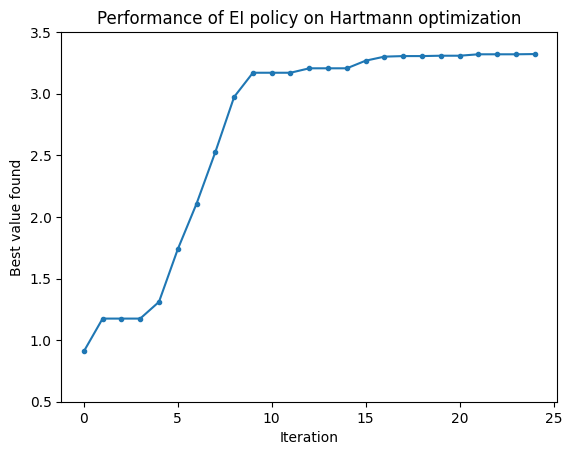

In [191]:
plt.plot(EI_best,'.-')
# plt.plot(GI_best_dict[cost],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.ylim(0.5,3.5)
plt.title("Performance of EI policy on Hartmann optimization")

In [192]:
GI_best_dict = {}

In [218]:
def test_Gittins(seed, maximize, cost, num_iterations, GI_best_dict):
    
    torch.manual_seed(seed)
    
    objective = Hartmann(negate=maximize)

    x = torch.rand(20, 6, device=device, dtype=torch.float64, requires_grad=True)
    y = objective(x).unsqueeze(-1)  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    GI_best = [best_f] # This will store the best value

    for i in range(num_iterations):

        # Fit the model
    #     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Optimize GI
        GI = GittinsIndex(model=model, cost=cost, maximize=maximize)
        if maximize:
            new_point, new_point_GI = optimize_acqf(
                acq_function=GI,
                bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),
                q=1,
                num_restarts=20,
                raw_samples=1024,
                options={'method': 'L-BFGS-B'},
            )
        else:
            neg_GI = lambda X: -GI(X)
            new_point, new_point_neg_GI = optimize_acqf(
                acq_function=neg_GI,
                bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]], dtype=torch.float64),
                q=1,
                num_restarts=20,
                raw_samples=1024,
                options={'method': 'L-BFGS-B'},
            )
            new_point_GI = -new_point_neg_GI

        new_value = objective(new_point)

        print("Iteration:", i)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())

        #cross_validation(x,y,nu=0.5)


        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value.unsqueeze(-1)))

        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        GI_best.append(best_f)
        print("best oberved value:", best_f)
        print()
        
    GI_best_dict[cost] = GI_best

In [221]:
cost=0.01
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.30932704 0.06528693 0.43748978 0.02574322 0.5051972  0.6650426 ]]
new value: 1.1653131246566772
best oberved value: 1.1653131246566772

Iteration: 1
new point: [[0.35169894 0.09895837 0.4114299  0.         0.40331516 0.6419697 ]]
new value: 1.3500422239303589
best oberved value: 1.3500422239303589

Iteration: 2
new point: [[0.38308752 0.01741079 0.37528098 0.         0.32256445 0.68276304]]
new value: 1.3165398836135864
best oberved value: 1.3500422239303589

Iteration: 3
new point: [[0.40157473 0.08313625 0.33711633 0.         0.3880195  0.56094915]]
new value: 1.1143287420272827
best oberved value: 1.3500422239303589

Iteration: 4
new point: [[0.31990314 0.15973686 0.4239259  0.         0.3002576  0.68595874]]
new value: 1.5674445629119873
best oberved value: 1.5674445629119873

Iteration: 5
new point: [[0.3343105  0.22756709 0.42024484 0.         0.27280134 0.7747026 ]]
new value: 1.3293917179107666
best oberved value: 1.5674445629119873

Iteration: 6
new

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.01) on Hartmann')

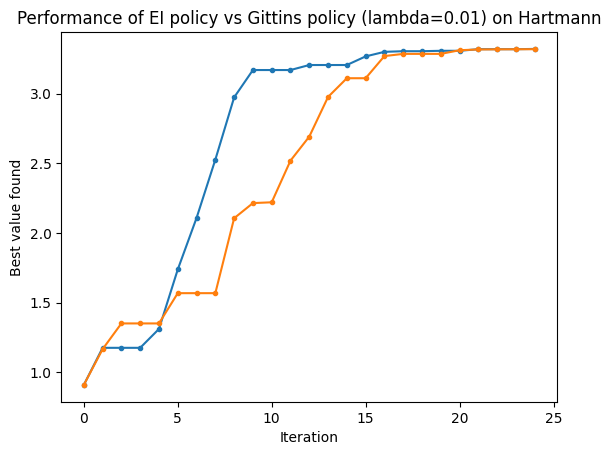

In [222]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={}) on Hartmann".format(cost))

In [223]:
cost=0.001
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.3363665  0.0666474  0.38682202 0.         0.43777794 0.68076134]]
new value: 1.1952272653579712
best oberved value: 1.1952272653579712

Iteration: 1
new point: [[0.30369836 0.         0.41952813 0.04811723 0.36228663 0.8339167 ]]
new value: 1.3669235706329346
best oberved value: 1.3669235706329346

Iteration: 2
new point: [[0.37223473 0.         0.36271438 0.         0.4848323  0.9592301 ]]
new value: 0.4056633412837982
best oberved value: 1.3669235706329346

Iteration: 3
new point: [[0.23272273 0.         0.4921363  0.11595607 0.29201433 0.7500699 ]]
new value: 2.2641472816467285
best oberved value: 2.2641472816467285

Iteration: 4
new point: [[0.22518653 0.         0.5303084  0.14118922 0.16556436 0.6975758 ]]
new value: 1.867010474205017
best oberved value: 2.2641472816467285

Iteration: 5
new point: [[0.14559156 0.         0.49959406 0.12265246 0.3164714  0.7391718 ]]
new value: 2.3551220893859863
best oberved value: 2.3551220893859863

Iteration: 6
new 

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.001) on Hartmann')

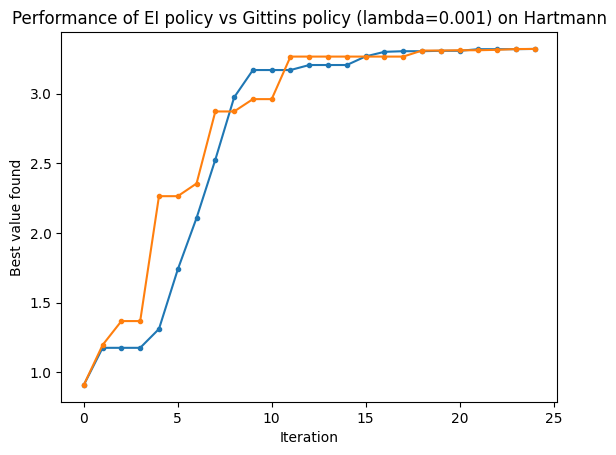

In [224]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={}) on Hartmann".format(cost))

In [204]:
cost=0.0001
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.35233927 0.06444084 0.36975688 0.         0.38415256 0.69133997]]
new value: 1.310139775276184
best oberved value: 1.310139775276184

Iteration: 1
new point: [[0.3087659  0.         0.39282304 0.01096138 0.33561915 0.9012375 ]]
new value: 0.9304370880126953
best oberved value: 1.310139775276184

Iteration: 2
new point: [[0.3671017  0.1606388  0.44575655 0.         0.17415127 0.61834234]]
new value: 1.1267467737197876
best oberved value: 1.310139775276184

Iteration: 3
new point: [[0.49277845 0.         0.35847855 0.         0.39439395 0.65487665]]
new value: 0.9557662010192871
best oberved value: 1.310139775276184

Iteration: 4
new point: [[0.3149187  0.         0.22462058 0.         0.26980147 0.5887971 ]]
new value: 1.141880750656128
best oberved value: 1.310139775276184

Iteration: 5
new point: [[0.3602341  0.27840233 0.21977644 0.         0.4008967  0.68471926]]
new value: 1.0248465538024902
best oberved value: 1.310139775276184

Iteration: 6
new point: 

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.0001) on Hartmann')

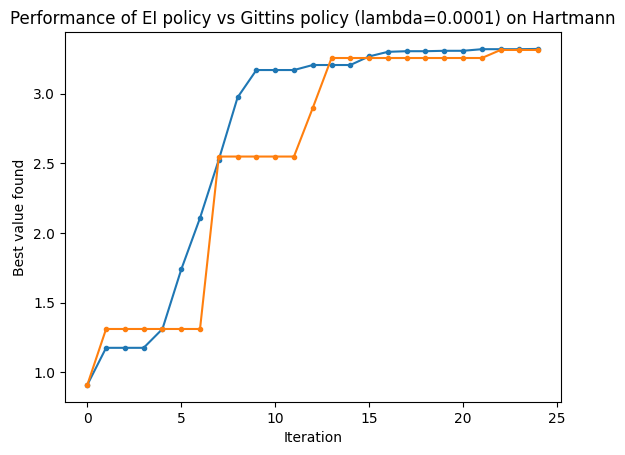

In [205]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={}) on Hartmann".format(cost))

In [206]:
cost=0.005
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.31841084 0.06369918 0.4161441  0.01627169 0.48288703 0.6721599 ]]
new value: 1.169157862663269
best oberved value: 1.169157862663269

Iteration: 1
new point: [[0.3651182  0.12183269 0.41228843 0.         0.3623524  0.6237379 ]]
new value: 1.4259772300720215
best oberved value: 1.4259772300720215

Iteration: 2
new point: [[0.37919497 0.06913394 0.4296215  0.         0.23382533 0.67193097]]
new value: 1.3038045167922974
best oberved value: 1.4259772300720215

Iteration: 3
new point: [[0.4255698  0.08580265 0.34557426 0.         0.34711042 0.5377313 ]]
new value: 1.113323450088501
best oberved value: 1.4259772300720215

Iteration: 4
new point: [[0.33056137 0.23943529 0.42074725 0.         0.29320124 0.6382775 ]]
new value: 1.5097826719284058
best oberved value: 1.5097826719284058

Iteration: 5
new point: [[0.38113463 0.28612092 0.4484677  0.         0.34213933 0.68359786]]
new value: 1.3704919815063477
best oberved value: 1.5097826719284058

Iteration: 6
new po

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.005) on Hartmann')

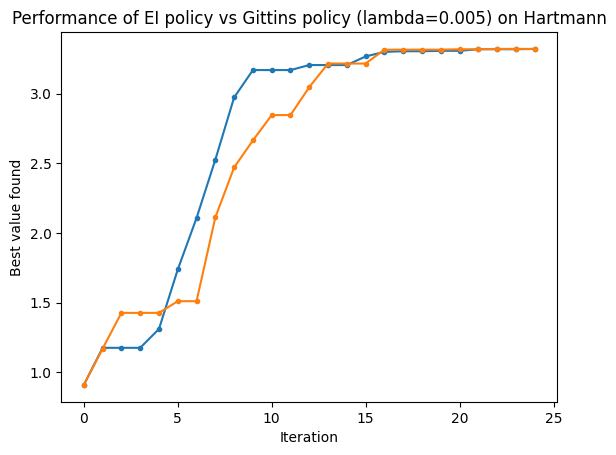

In [207]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={}) on Hartmann".format(cost))

In [225]:
cost=0.1
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.30432633 0.0699859  0.59878486 0.02260926 0.558548   0.6433927 ]]
new value: 1.0366276502609253
best oberved value: 1.0366276502609253

Iteration: 1
new point: [[0.29548576 0.07778666 0.520919   0.04664743 0.5519483  0.64350826]]
new value: 1.1710922718048096
best oberved value: 1.1710922718048096

Iteration: 2
new point: [[0.29212943 0.07974701 0.48491156 0.05463873 0.54697955 0.64428806]]
new value: 1.190793514251709
best oberved value: 1.190793514251709

Iteration: 3
new point: [[0.2920938  0.07931293 0.47668302 0.05558936 0.5449229  0.6450426 ]]
new value: 1.1918755769729614
best oberved value: 1.1918755769729614

Iteration: 4
new point: [[0.29229903 0.07905694 0.47565156 0.05557737 0.54444486 0.6452698 ]]
new value: 1.192002534866333
best oberved value: 1.192002534866333

Iteration: 5
new point: [[0.29242453 0.07891455 0.47530833 0.05552589 0.544217   0.64538044]]
new value: 1.1920632123947144
best oberved value: 1.1920632123947144

Iteration: 6
new poi

Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy (lambda=0.1) on Hartmann')

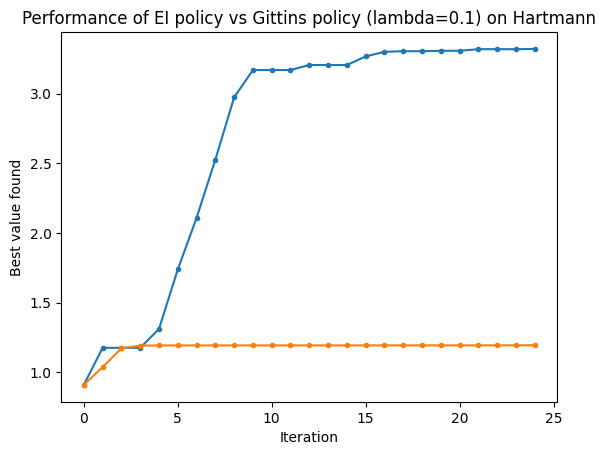

In [226]:
plt.plot(EI_best,'.-')
plt.plot(GI_best_dict[cost],'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy (lambda={}) on Hartmann".format(cost))

In [11]:
# from botorch.test_functions import Hartmann
# from botorch.acquisition import UpperConfidenceBound

seed = 42

maximize = True 

num_iterations = 24

torch.manual_seed(seed)

objective = Hartmann(negate=maximize)

x = torch.rand(20, 6, device=device, dtype=torch.float64, requires_grad=True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
UCB_best = [best_f] # This will store the best value

for i in range(num_iterations):
    
    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize UCB
    BoTorch_UCB = UpperConfidenceBound(model=model, beta=2.7, maximize=maximize)
    new_point, new_point_UCB = optimize_acqf(
        acq_function=BoTorch_UCB,
        bounds=torch.tensor([[0., 0., 0., 0., 0., 0.],[1., 1., 1., 1., 1., 1.]]),
        q=1,
        num_restarts=20,
        raw_samples=1024,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    UCB_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.31191    0.06454775 0.430678   0.02292935 0.49879792 0.6673163 ]]
new value: 1.1653777360916138
best oberved value: 1.1653777360916138

Iteration: 1
new point: [[0.35664433 0.10702039 0.41121218 0.         0.3893343  0.63546646]]
new value: 1.38190758228302
best oberved value: 1.38190758228302

Iteration: 2
new point: [[0.3898936  0.02544425 0.38642192 0.         0.29659504 0.67128235]]
new value: 1.3255714178085327
best oberved value: 1.38190758228302

Iteration: 3
new point: [[0.40930378 0.1084847  0.33447644 0.         0.37700006 0.54692626]]
new value: 1.1083426475524902
best oberved value: 1.38190758228302

Iteration: 4
new point: [[0.3215834  0.17852059 0.43299404 0.         0.2878335  0.669749  ]]
new value: 1.5690511465072632
best oberved value: 1.5690511465072632

Iteration: 5
new point: [[0.35330498 0.24484682 0.44092786 0.         0.28469414 0.7479171 ]]
new value: 1.379170536994934
best oberved value: 1.5690511465072632

Iteration: 6
new point: [

Text(0.5, 1.0, 'Performance of UCB policy (beta=2.7) on Hartmann optimization')

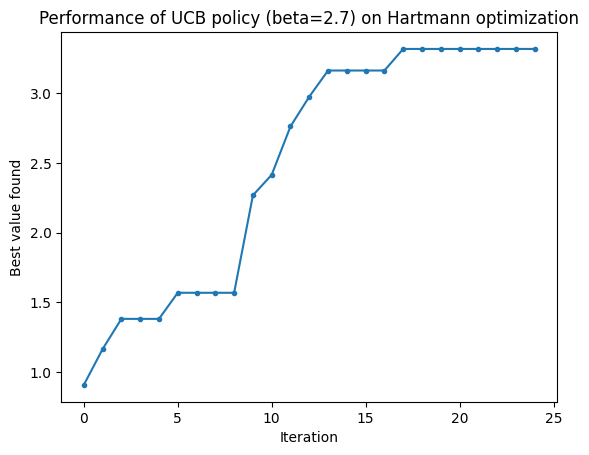

In [12]:
plt.plot(UCB_best,'.-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of UCB policy (beta=2.7) on Hartmann optimization")